In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import seaborn.objects as so
%matplotlib inline
sns.set_theme(font='Liberation Serif',
              rc={'figure.figsize': (7.5,3.75),
                  'font.size': 11,
                  'figure.dpi': 300,
                 })
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.miscmodels.ordinal_model import OrderedModel

In [2]:
DATA = '../data/'

## Some Descriptive Stats

In [65]:
df = pd.read_csv(DATA+'test_prediction_results.csv', index_col=0)
cefrType = pd.CategoricalDtype(categories=['A1', 'A2', 'B1', 'B2', 'C1'],
                               ordered=True)
l1Type = pd.CategoricalDtype(categories=['Portuguese', 'Mandarin', 'Russian', 'Spanish', 'Arabic', 'German'],
                             ordered=True)

df.head(1)

,writing_id,learner_id,labels,cefr,grade,text,preds
0,1205367,118089,Arabic,A2,90,"\n\t Next monday evening, the final football ...",Arabic


In [54]:
# Counts of CEFR
df1 = df.groupby(['labels', 'cefr']).count().reset_index()[['labels', 'cefr', 'text']]
pd.pivot(df1, columns='labels', values='text', index='cefr').reset_index().to_csv('table.csv')

In [61]:
# Average Word Counts
df1 = df.groupby('labels')['word_count'].std().reset_index()
df1.transpose().to_csv('table.csv')

In [64]:
print(df['word_count'].mean())
print(df['word_count'].std())

89.32860933882898
8.39782813755407


In [68]:
# Average Score
# Average Word Counts
df1 = df.groupby('labels')['grade'].mean().reset_index()
df1.transpose().to_csv('table.csv')

In [67]:
print(df['grade'].mean())
print(df['grade'].std())

89.32860933882898
8.39782813755407


## Get additional metadata

In [66]:
df = df.merge(pd.read_parquet('../data/efcamdat_shatz_distro.parquet'),
              how='inner',
              on=['learner_id', 'writing_id', 'cefr', 'grade', 'text'])
df['cefr'] = df.cefr.astype(cefrType)
df['l1'] = df.l1.astype(l1Type)

In [62]:
df.columns

Index(['writing_id', 'learner_id', 'labels', 'cefr', 'grade', 'text', 'preds',
       'learner_id_categorical', 'nationality', 'l1', 'cefr_numeric', 'level',
       'unit', 'topic_id_original', 'topic_id_original_categorical',
       'topic_id', 'topic_id_categorical', 'text_number_per_learner_in_task',
       'topic', 'secondary_topic', 'topic_to_keep', 'date', 'time',
       'wordcount', 'mtld', 'text_corrected', 'sample'],
      dtype='object')

In [68]:
df.groupby(['l1']).learner_id.nunique()

l1
Portuguese    1817
Mandarin      1257
Russian        828
Spanish        753
Arabic         683
German         676
Name: learner_id, dtype: int64

In [70]:
df[~df['cefr'].isin(['B2', 'C1'])].groupby(['l1', 'cefr']).writing_id.agg(['count']).unstack(level=1)

count                 
cefr          A1    A2   B1 B2 C1
l1                               
Portuguese  1440   782  437  0  0
Mandarin    1445  1013  394  0  0
Russian     1259   985  532  0  0
Spanish     1623   765  421  0  0
Arabic      1525   868  307  0  0
German       918   921  699  0  0

## Getting started on looking at the predictions

In [74]:
df['true_positive'] = df.apply(lambda x: 1 if x['preds'] == x['labels'] else 0, axis=1)

### By prompt

In [ ]:
prompt_stats = (df
                .groupby(['topic', 'cefr'])
                .agg(count=('true_positive', 'count'),
                     acc=('true_positive', 'mean'),
                     wordcount=('wordcount', 'mean'),
                    )
                .reset_index(level='cefr')
                # .sort_values(by='acc')
               )


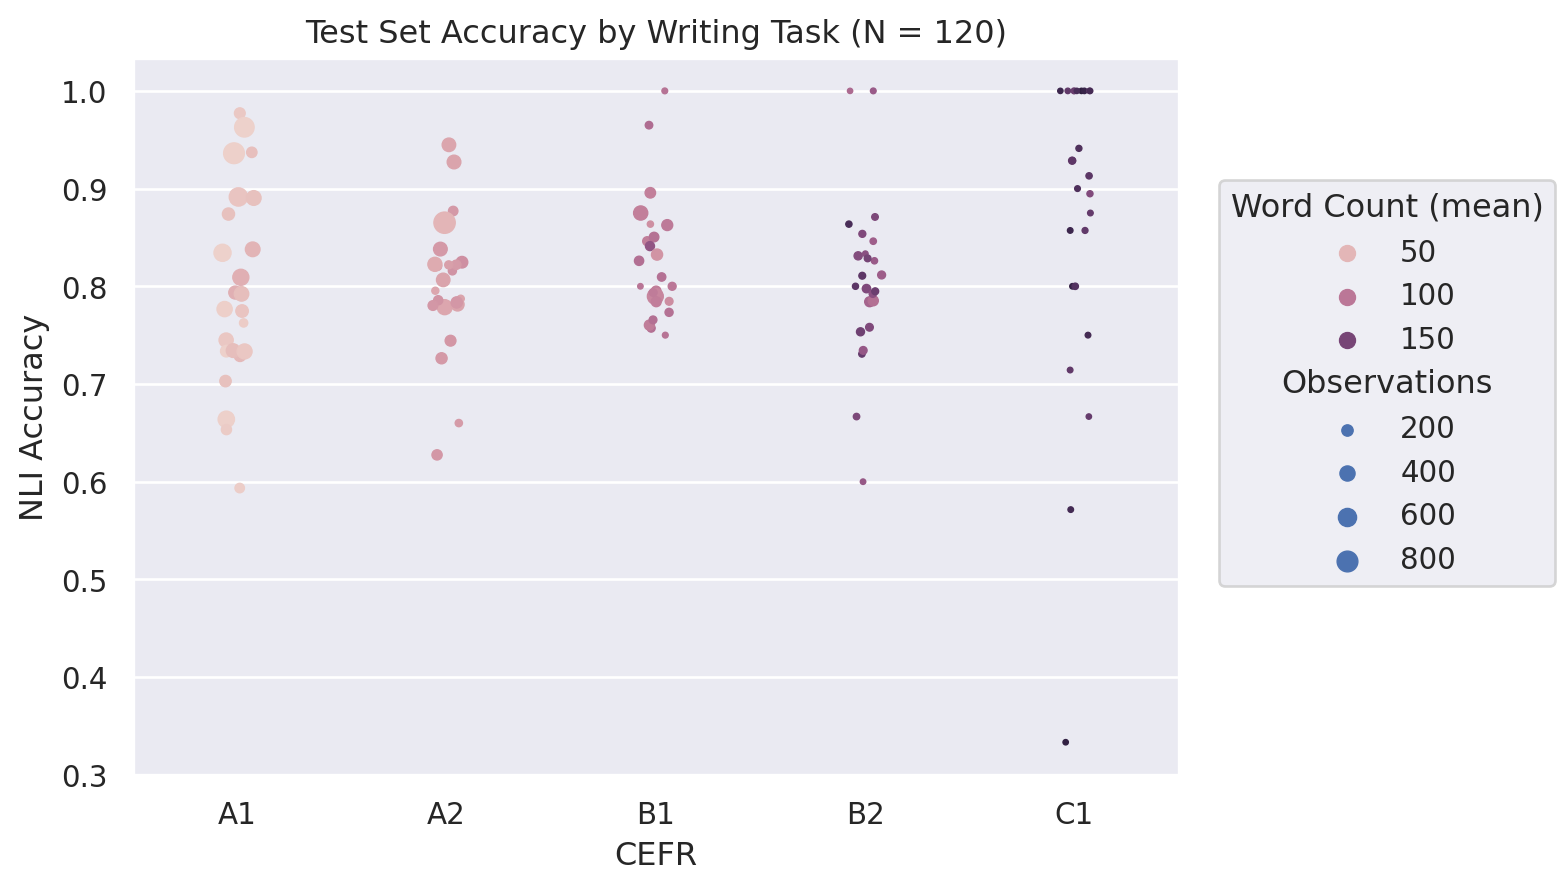

In [79]:
import seaborn.objects as so

(so
 .Plot(data=prompt_stats, x='cefr', y='acc', color='wordcount', pointsize='count')
 .add(so.Dot(), so.Jitter())
 .label(
     title='Test Set Accuracy by Writing Task (N = 120)',
     x='CEFR',
     y='NLI Accuracy',
     color='Word Count (mean)',
     pointsize='Observations',
 ) )
                         

### Textual Overlap between Writing Task Responses Predictive of Model Accuracy?

Some writing tasks may involve a significant amount of template language, which would have a negative effect on model performance.

Is there a relationship between within-task text overlap and model accuracy?[prompt_stats.cefr.isin(['A1', 'A2', 'B1'])][prompt_stats.cefr.isin(['A1', 'A2', 'B1'])]

In [118]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer_params = dict(
    analyzer='word',
    token_pattern=r'(?u)\b\w\w+\b',
    lowercase=True,
    strip_accents='ascii',
    stop_words=None,
    min_df=1,
    ngram_range=(3,3),
)

cv = CountVectorizer(**vectorizer_params)
tv = TfidfVectorizer(**vectorizer_params, use_idf=True)

In [150]:
from sklearn.metrics.pairwise import cosine_similarity

def textual_overlap(sample):
    return np.mean(cosine_similarity(tv.fit_transform(sample)))

x = (df
     .groupby('topic')
     .filter(lambda x: len(x) > 100)
     .groupby('topic')
     .agg(cos_sim=('text', textual_overlap),
          observations=('writing_id', 'count'),
          acc=('true_positive', 'mean'),
          cefr=('cefr', pd.Series.mode),
         )
    )

In [151]:
x.corr()

,cos_sim,observations,acc
cos_sim,1.000000,-0.359530,-0.444415
observations,-0.359530,1.000000,0.298367
acc,-0.444415,0.298367,1.000000


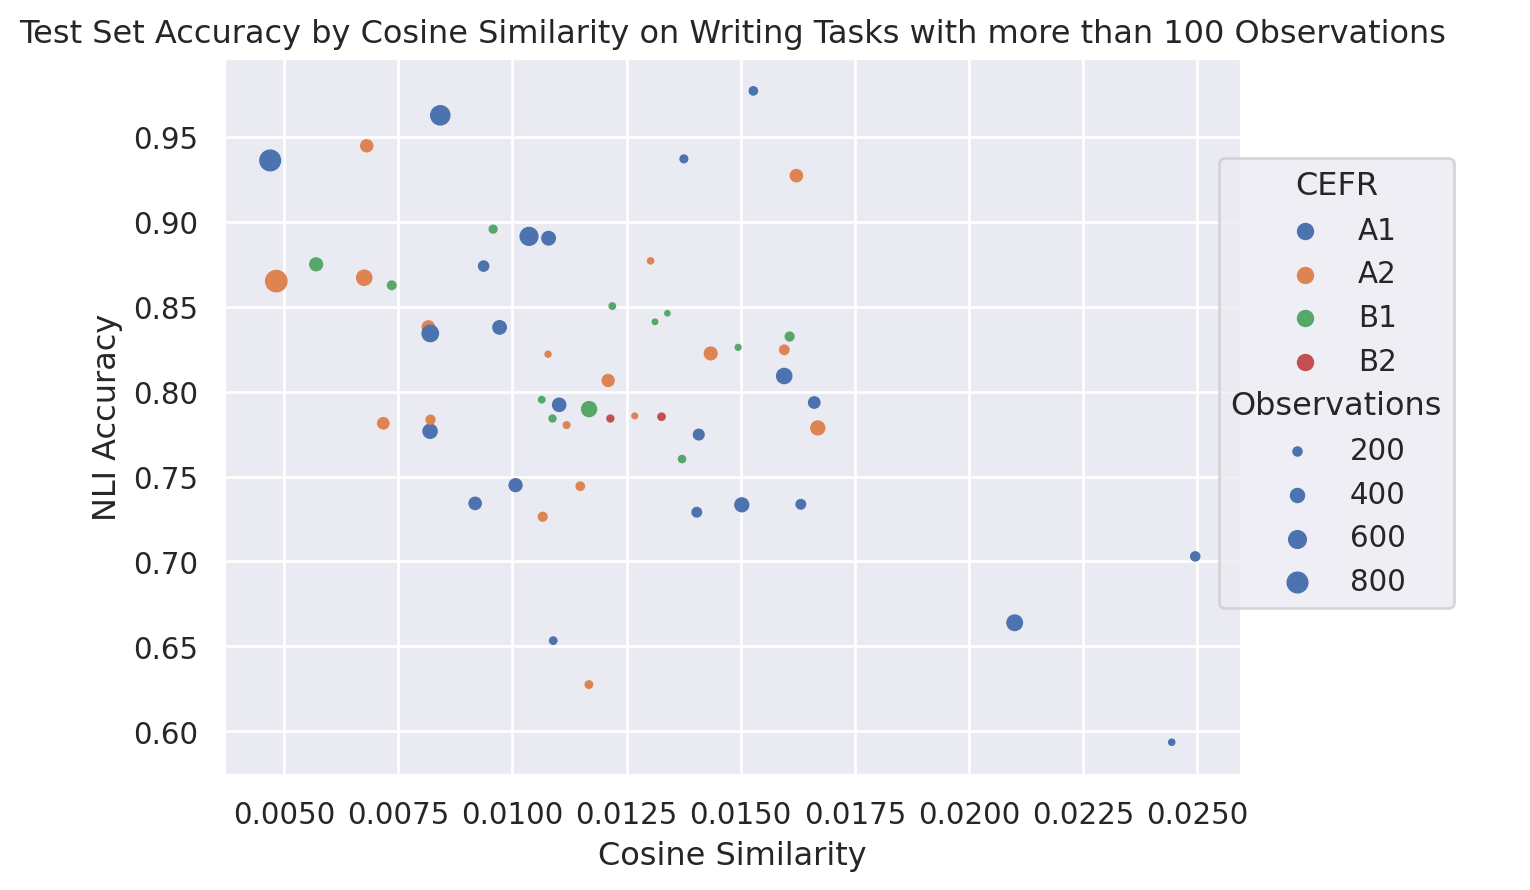

In [152]:
(so
 .Plot(data=x, x='cos_sim', y='acc', color='cefr', pointsize='observations')
 .add(so.Dot())
 .label(
     title='Test Set Accuracy by Cosine Similarity on Writing Tasks with more than 100 Observations',
     x='Cosine Similarity',
     y='NLI Accuracy',
     color='CEFR',
     pointsize='Observations',
 )
)


### Prediction accuracy by l1

In [19]:
order = df.groupby('labels').true_positive.mean()
print(order.sort_values())
df['labels'] = df['labels'].astype('category').cat.reorder_categories(order.sort_values().index)

labels
Portuguese    0.732534
Spanish       0.800744
German        0.814947
Russian       0.829131
Arabic        0.856243
Mandarin      0.894488
Name: true_positive, dtype: float64


<function matplotlib.pyplot.show(close=None, block=None)>

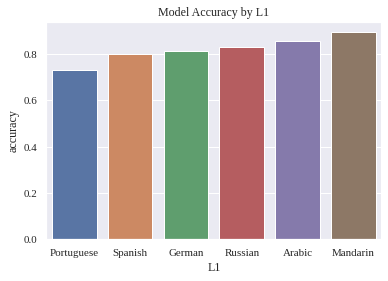

In [20]:
sns.barplot(data=df, x='labels', y='true_positive', ci=None, order=order.sort_values().index)
plt.title('Model Accuracy by L1')
plt.ylabel('accuracy')
plt.xlabel('L1')
plt.show

In [23]:
log_reg = smf.logit("true_positive ~ labels", data=df).fit()
log_reg.summary()
#pd.DataFrame(log_reg.summary().tables[1]).to_csv('table.csv')

Optimization terminated successfully.
         Current function value: 0.460409
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          true_positive   No. Observations:                17711
Model:                          Logit   Df Residuals:                    17705
Method:                           MLE   Df Model:                            5
Date:                Mon, 24 Oct 2022   Pseudo R-squ.:                 0.01775
Time:                        22:22:15   Log-Likelihood:                -8154.3
converged:                       True   LL-Null:                       -8301.7
Covariance Type:            nonrobust   LLR p-value:                 1.329e-61
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.0075      0.042     23.741      0.000       0.924       1.091
labels[T.Spanish]      0.3834      0.063      6.123      0.000       0.261       0.506
labels[T.German]       0.4750      0.063      7.561      0.000       0.352       0.598
labels[T.Russian]      0.5720      0.064      8.886      0.000       0.446       0.698
labels[T.Arabic]       0.7769      0.068     11.402      0.000       0.643       0.910
labels[T.Mandarin]     1.1299      0.073     15.399      0.000       0.986       1.274
======================================================================================
"""

### Accuracy by CEFR

Text(0, 0.5, 'accuracy')

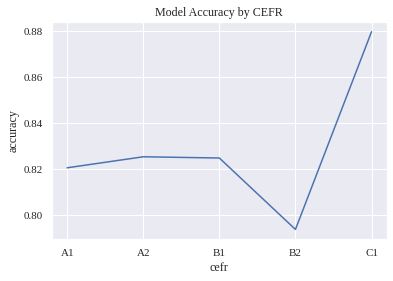

In [24]:
sns.lineplot(data=df, x='cefr', y='true_positive', ci=None)
plt.title('Model Accuracy by CEFR')
plt.ylabel('accuracy')

In [27]:
OrderedModel.from_formula("true_positive ~ cefr", df,
                          distr='logit').fit().summary()

# pd.DataFrame(OrderedModel.from_formula("true_positive ~ cefr", df,
#                           distr='logit').fit().summary().tables[1]).to_csv('table.csv')

Optimization terminated successfully.
         Current function value: 0.468361
         Iterations: 323
         Function evaluations: 523
Optimization terminated successfully.
         Current function value: 0.468361
         Iterations: 323
         Function evaluations: 523


<Figure size 2250x1125 with 0 Axes>

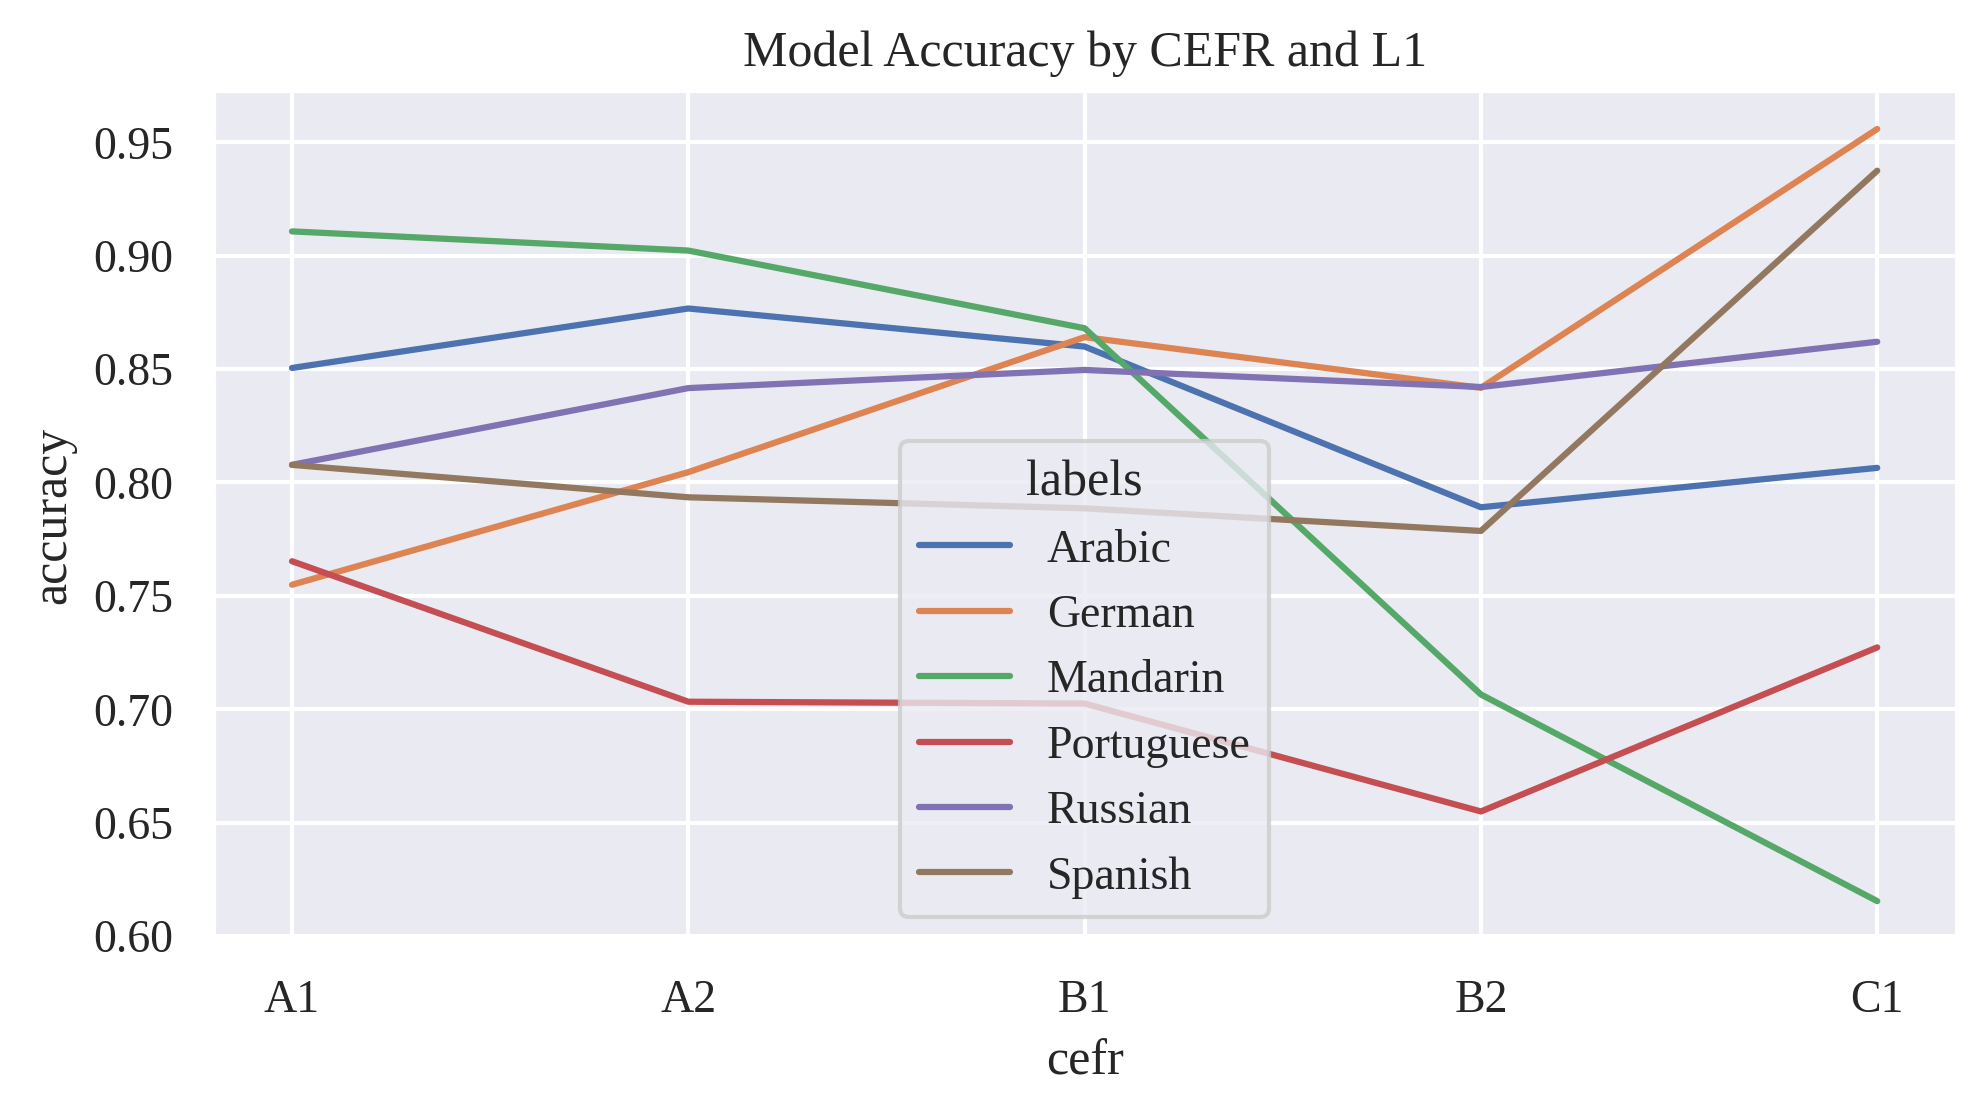

<Figure size 2250x1125 with 0 Axes>

In [76]:
sns.lineplot(data=df, x='cefr', y='true_positive', hue='labels', errorbar=None)
plt.title('Model Accuracy by CEFR and L1')
plt.ylabel('accuracy')
plt.figure(figsize=(7.5,3.75))

In [32]:
OrderedModel.from_formula("true_positive ~ cefr + labels + cefr*labels", df,
                          distr='logit').fit(maxiter=100000).summary()

Optimization terminated successfully.
         Current function value: 0.459246
         Iterations: 14543
         Function evaluations: 17187


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:          true_positive   Log-Likelihood:                -8133.7
Model:                   OrderedModel   AIC:                         1.633e+04
Method:            Maximum Likelihood   BIC:                         1.656e+04
Date:                Mon, 24 Oct 2022                                         
Time:                        22:44:21                                         
No. Observations:               17711                                         
Df Residuals:                   17681                                         
Df Model:                          30                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
cefr[T.A2]                       -0.1097      0.102     -1.080      0.280      -0.309       0.089
cefr[T.B1]                        0.2680      0.135      1.988      0.047       0.004       0.532
cefr[T.B2]                       -0.1816      0.197     -0.923      0.356      -0.568       0.204
cefr[T.C1]                       -0.0673      0.403     -0.167      0.868      -0.858       0.723
labels[T.Spanish]                 0.4549      0.090      5.045      0.000       0.278       0.632
labels[T.German]                  0.0384      0.099      0.388      0.698      -0.155       0.232
labels[T.Russian]                 0.3284      0.095      3.470      0.001       0.143       0.514
labels[T.Arabic]                  0.6402      0.095      6.733      0.000       0.454       0.827
labels[T.Mandarin]                1.0090      0.105      9.572      0.000       0.802       1.216
cefr[T.A2]:labels[T.Spanish]     -0.2197      0.149     -1.472      0.141      -0.512       0.073
cefr[T.B1]:labels[T.Spanish]     -0.7786      0.187     -4.158      0.000      -1.146      -0.412
cefr[T.B2]:labels[T.Spanish]     -0.2819      0.290     -0.971      0.332      -0.851       0.287
cefr[T.C1]:labels[T.Spanish]     -0.0059      0.768     -0.008      0.994      -1.511       1.499
cefr[T.A2]:labels[T.German]       0.3257      0.152      2.141      0.032       0.028       0.624
cefr[T.B1]:labels[T.German]       0.5083      0.193      2.633      0.008       0.130       0.887
cefr[T.B2]:labels[T.German]       0.4994      0.246      2.026      0.043       0.016       0.982
cefr[T.C1]:labels[T.German]       0.6164      0.475      1.298      0.194      -0.315       1.548
cefr[T.A2]:labels[T.Russian]      0.2977      0.152      1.962      0.050       0.000       0.595
cefr[T.B1]:labels[T.Russian]     -0.1549      0.191     -0.810      0.418      -0.530       0.220
cefr[T.B2]:labels[T.Russian]      0.3834      0.282      1.359      0.174      -0.170       0.936
cefr[T.C1]:labels[T.Russian]      0.0989      0.631      0.157      0.875      -1.137       1.335
cefr[T.A2]:labels[T.Arabic]       0.3041      0.162      1.875      0.061      -0.014       0.622
cefr[T.B1]:labels[T.Arabic]      -0.4808      0.215     -2.239      0.025      -0.902      -0.060
cefr[T.B2]:labels[T.Arabic]      -0.9586      0.280     -3.421      0.001      -1.508      -0.409
cefr[T.C1]:labels[T.Arabic]       0.2411      0.680      0.355      0.723      -1.092       1.574
cefr[T.A2]:labels[T.Mandarin]     0.2745      0.172      1.594      0.111      -0.063       0.612
cefr[T.B1]:labels[T.Mandarin]    -0.7872      0.210     -3.756      0.000      -1.198      -0.376
cefr[T.B2]:labels[T.Mandarin]    -0.8556      0.323     -2.651      0.008      -1.488      -0.223
cefr[T.C1]:labels[T.Mandarin]    -0.5902      0.825     -0.716      0.474      -2.206       1.026
0.0/1.0                   

### Accuracy by score

In [35]:
def gradeGroup(grade):
    if grade < 80:
        return '< 80'
    elif 80 <= grade < 85:
        return '80 - 85'
    elif 85 <= grade < 90:
        return '85 - 90'
    elif 90 <= grade < 95:
        return '90 - 95'
    elif 95 <= grade:
        return '95 - 100'

df['grade_group'] = df['grade'].apply(lambda x: gradeGroup(x))
df['grade_group'] = pd.Categorical(df['grade_group'],
                                   categories=['< 80', '80 - 85', '85 - 90', '90 - 95', '95 - 100'],
                                   ordered=True)

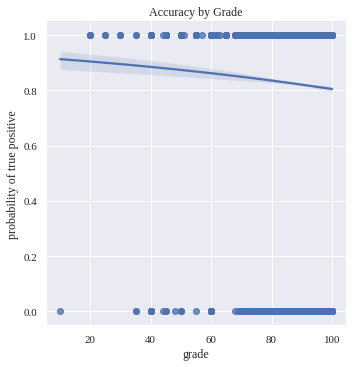

In [40]:
sns.lmplot(data=df, x='grade', y='true_positive', logistic=True)
plt.title('Accuracy by Grade')
plt.ylabel('probability of true positive')
plt.show()

In [41]:
log_reg = smf.logit("true_positive ~ grade", data=df).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.468213
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:          true_positive   No. Observations:                17711
Model:                          Logit   Df Residuals:                    17709
Method:                           MLE   Df Model:                            1
Date:                Mon, 24 Oct 2022   Pseudo R-squ.:                0.001104
Time:                        22:54:28   Log-Likelihood:                -8292.5
converged:                       True   LL-Null:                       -8301.7
Covariance Type:            nonrobust   LLR p-value:                 1.851e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4599      0.223     11.015      0.000       2.022       2.898
grade         -0.0104      0.

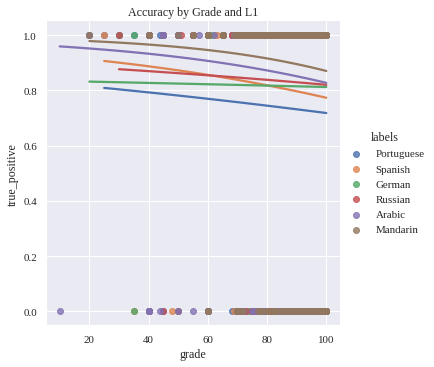

In [42]:
sns.lmplot(data=df, x='grade', y='true_positive', hue='labels', logistic=True, ci=None)
plt.title('Accuracy by Grade and L1')
plt.show()

In [63]:
log_reg = smf.logit("true_positive ~ grade + labels + grade*labels", data=df).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.459682
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:          true_positive   No. Observations:                17711
Model:                          Logit   Df Residuals:                    17699
Method:                           MLE   Df Model:                           11
Date:                Thu, 20 Oct 2022   Pseudo R-squ.:                 0.01930
Time:                        20:55:42   Log-Likelihood:                -8141.4
converged:                       True   LL-Null:                       -8301.7
Covariance Type:            nonrobust   LLR p-value:                 4.108e-62
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      3.3419      0.562      5.949      0.000      

### Accuracy by word count

Text(0.5, 1.0, 'Model Accuracy Depending on Essay Word Count and CEFR')

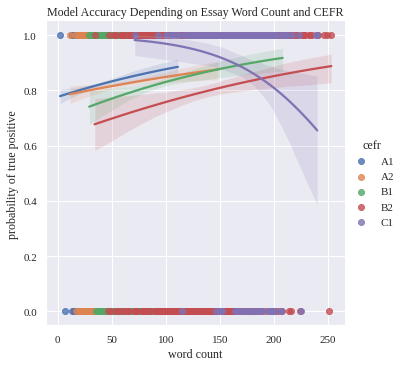

In [46]:
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
sns.lmplot(data=df, x='word_count', y='true_positive', logistic=True, hue = 'cefr')
plt.ylabel('probability of true positive')
plt.xlabel('word count')
plt.title('Model Accuracy Depending on Essay Word Count and CEFR')

In [101]:
log_reg = smf.logit("true_positive ~ word_count*cefr", data=df).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.467130
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:          true_positive   No. Observations:                17711
Model:                          Logit   Df Residuals:                    17701
Method:                           MLE   Df Model:                            9
Date:                Thu, 20 Oct 2022   Pseudo R-squ.:                0.003416
Time:                        22:01:26   Log-Likelihood:                -8273.3
converged:                       True   LL-Null:                       -8301.7
Covariance Type:            nonrobust   LLR p-value:                 5.728e-09
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 1.2483      0.083     14.952      0.000       1.085       1.